In [1]:
import sys
sys.path.insert(0, "../")
from chunkgfn.datamodules.rna_binding import RNABindingModule
from chunkgfn.gfn.tb_gfn import TBGFN
from chunkgfn.gfn.tb_gfn_variable import TBGFN_Variable
from chunkgfn.gfn.tb_gfn_chunk_replacement import TBGFN_Chunk_Replacement

from torch.distributions import Categorical
from scipy.stats import linregress, spearmanr

import torch
import lightning as L
from tqdm.notebook import tqdm
from einops import repeat, rearrange
import pandas as pd
import matplotlib.pyplot as plt
from polyleven import levenshtein
import wandb
from tqdm.notebook import tqdm

In [2]:
def to_strings(states: torch.Tensor) -> list[str]:
    """Convert the states to raw data.
    Args:
        states (torch.Tensor[batch_size, max_len, dim]): Batch of states.
    Returns:
        raw (list[str]): List of states in their string representation.
    """
    atomic_tokens = ["<EOS>", "A", "C", "G", "U"]
    padding_token = -torch.ones(len(atomic_tokens))
    strings = []
    for state in states.cpu():
        # Cut the state before it arrives at [-1,-1,...]
        nonzero = (state == padding_token).nonzero()
        if len(nonzero) > 0:
            state = state[: nonzero[0][0]]

        indices = state.argmax(dim=-1)
        strings.append("".join([atomic_tokens[i] for i in indices]))
    return strings

In [3]:
import numpy as np

def calculate_mean_std(iteration_key, value_key, *dicts):
    key_value = {}
    all_iterations = set()
    for i, d in enumerate(dicts):
        iterations = d[iteration_key]
        values = d[value_key]

        key_value[i] = {k: v for (k,v) in zip(iterations, values)}
        all_iterations = all_iterations.union(set(iterations))
    
    all_iterations = sorted(all_iterations)
    mean = []
    std = []
    for i in all_iterations:
        values = [key_value[j][i]  for j in key_value if i in key_value[j]]
        mean.append(np.mean(values))
        std.append(np.std(values))
    return all_iterations, mean, std
    

# Learning Curves

In [4]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"group": "rna_binding", "tags": "final", "config.data.task": "L14_RNA1"})
columns = ["_step", 'train/num_modes', 'trainer/global_step', "epoch"]

In [7]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"group": "rna_binding", "tags": "final", "config.data.task": "L14_RNA1"})
columns = ["_step", 'train/num_modes', 'trainer/global_step', "epoch"]
# Group runs by algorithm and then length
experiments = {}
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    if "chunk_replacement" in name:
        algorithm = "chunk_replacement"
    elif "chunk" in name:
        algorithm = "chunk"
    else:
        algorithm = "no_chunk"

    if algorithm not in experiments:
        experiments[algorithm] = [summary]
    else:
        experiments[algorithm].append(summary)
    

  0%|          | 0/9 [00:00<?, ?it/s]

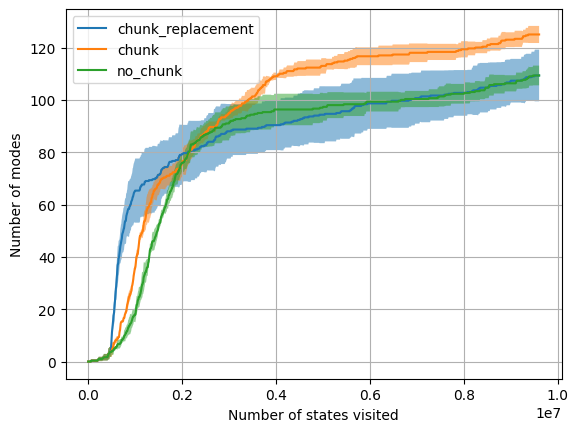

In [21]:
for algorithm in ["chunk_replacement", "chunk", "no_chunk"]:
    all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments[algorithm])
    all_iterations = 256*np.array(all_iterations)
    plt.plot(all_iterations, mean, label=algorithm)
    plt.fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha=0.5)
plt.ylabel("Number of modes")
plt.xlabel("Number of states visited")
plt.legend()
plt.grid()
plt.show()

In [4]:
def get_samples(jobid, seed, gfn_approach, n_samples=2**10):
    
    dm = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{jobid}/checkpoints/last.ckpt")
    if gfn_approach == "chunk_normal":
        gfn = TBGFN_Variable.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{jobid}/checkpoints/last.ckpt")
    elif gfn_approach == "chunk_replacement":
        gfn = TBGFN_Chunk_Replacement.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{jobid}/checkpoints/last.ckpt")
    elif gfn_approach == "no_chunk":
        gfn = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{jobid}/checkpoints/last.ckpt")
    dm.action_frequency = torch.zeros(len(dm.actions))
    batch_size = n_samples

    L.seed_everything(seed)
    with torch.no_grad():
    
        s0 = dm.s0.to(gfn.device)
        state = repeat(s0, " ... -> b ...", b=batch_size)
        bs = state.shape[0]

        # Start unrolling the trajectories
        actions = []
        trajectories = []
        dones = []
        done = torch.zeros((bs)).to(state).bool()
        trajectory_length = (
            torch.zeros((bs)).to(state).long()
        )  # This tracks the length of trajetcory for each sample in the batch

        while not done.all():
            action_indices = dm.action_indices
            library_embeddings = []
            for action, indices in action_indices.items():
                library_embeddings.append(
                    gfn.action_model(
                        torch.LongTensor(indices).to(gfn.device).unsqueeze(0)
                    )
                )
            library_embeddings = torch.cat(library_embeddings, dim=0)
            action_embedding = gfn.forward_model(
                dm.preprocess_states(state)
            )
            dim = action_embedding.shape[-1]
            p_f_s = torch.einsum("bd, nd -> bn", action_embedding, library_embeddings) / (
                dim**0.5
            )  # Same as in softmax

            uniform_dist_probs = torch.ones_like(p_f_s).to(p_f_s)

            valid_actions_mask = dm.get_forward_mask(state)

            p_f_s = torch.where(
                valid_actions_mask,
                p_f_s,
                torch.tensor(-1e6).to(p_f_s),
            )
            uniform_dist_probs = torch.where(
                valid_actions_mask,
                uniform_dist_probs,
                torch.tensor(0.0).to(uniform_dist_probs),
            )

            cat = Categorical(logits=p_f_s)

            act = cat.sample()

            new_state, done = dm.forward_step(state, act)
            trajectory_length += ~done  # Increment the length of the trajectory for each sample in the batch as long it's not done.

            actions.append(act)
            trajectories.append(state)
            dones.append(done.clone())

            state = new_state.clone()


        logreward = dm.compute_logreward(state).to(
                state.device
        )
        trajectories.append(state)
        dones.append(torch.ones((bs)).to(state).bool())
        trajectories = torch.stack(trajectories, dim=1)
        actions = torch.stack(actions, dim=1)
        dones = torch.stack(dones, dim=1)
    return logreward, state, actions, trajectories, dones

In [5]:
logreward, state, actions, trajectories, dones = get_samples(4714874, 2024, "chunk_normal", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().mean())
logreward, state, actions, trajectories, dones = get_samples(4714865, 1998, "chunk_normal", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().mean())
logreward, state, actions, trajectories, dones = get_samples(4714883, 42, "chunk_normal", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().mean())

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 2024


tensor(0.6855, device='cuda:0')


Seed set to 1998


tensor(0.6862, device='cuda:0')


Seed set to 42


tensor(0.6854, device='cuda:0')


In [6]:
logreward.exp().mean()

tensor(0.4015, device='cuda:0')

In [24]:
logreward, state, actions, trajectories, dones = get_samples(4714880, 2024, "no_chunk", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())
logreward, state, actions, trajectories, dones = get_samples(4714871, 1998, "no_chunk", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())
logreward, state, actions, trajectories, dones = get_samples(4714889, 42, "no_chunk", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())

Seed set to 2024


tensor(0.6811, device='cuda:0')


Seed set to 1998


tensor(0.6783, device='cuda:0')


Seed set to 42


tensor(0.6783, device='cuda:0')


In [25]:
logreward, state, actions, trajectories, dones = get_samples(4714877, 2024, "chunk_replacement", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())
logreward, state, actions, trajectories, dones = get_samples(4714868, 1998, "chunk_replacement", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())
logreward, state, actions, trajectories, dones = get_samples(4714886, 42, "chunk_replacement", n_samples=2**12)
print(torch.topk(logreward, k=100).values.exp().median())

Seed set to 2024


tensor(0.6920, device='cuda:0')


Seed set to 1998


tensor(0.6646, device='cuda:0')


Seed set to 42


tensor(0.6728, device='cuda:0')


In [6]:
chunk_14_jobids = [(4699988, 2024), (4699979, 1998), (4699997, 42)]
prior_14_jobids = [(4699994, 2024), (4699985, 1998), (4700003, 42)]

In [7]:
logreward_chunk = []
states_chunk = []
actions_chunk = []
trajectories_chunk = []
dones_chunk = []
for (jobid, seed) in tqdm(chunk_14_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, gfn_approach="chunk_normal", n_samples=2**12)
    logreward_chunk.append(logreward)
    states_chunk.append(state)
    actions_chunk.append(actions)
    trajectories_chunk.append(trajectories)
    dones_chunk.append(dones)
logreward_chunk = torch.cat(logreward_chunk, dim=0)
states_chunk = torch.cat(states_chunk, dim=0)
actions_chunk = torch.cat(actions_chunk, dim=0)
trajectories_chunk = torch.cat(trajectories_chunk, dim=0)
dones_chunk = torch.cat(dones_chunk, dim=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 2024
Seed set to 1998
Seed set to 42


In [22]:
logreward_prioritized = []
states_prioritized = []
actions_prioritized = []
trajectories_prioritized = []
dones_prioritized = []
for (jobid, seed) in tqdm(prior_14_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, gfn_approach="no_chunk", n_samples=2**12)
    logreward_prioritized.append(logreward)
    states_prioritized.append(state)
    actions_prioritized.append(actions)
    trajectories_prioritized.append(trajectories)
    dones_prioritized.append(dones)
logreward_prioritized = torch.cat(logreward_prioritized, dim=0)
states_prioritized = torch.cat(states_prioritized, dim=0)
actions_prioritized = torch.cat(actions_prioritized, dim=0)
trajectories_prioritized = torch.cat(trajectories_prioritized, dim=0)
dones_prioritized = torch.cat(dones_prioritized, dim=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 2024
Seed set to 1998
Seed set to 42


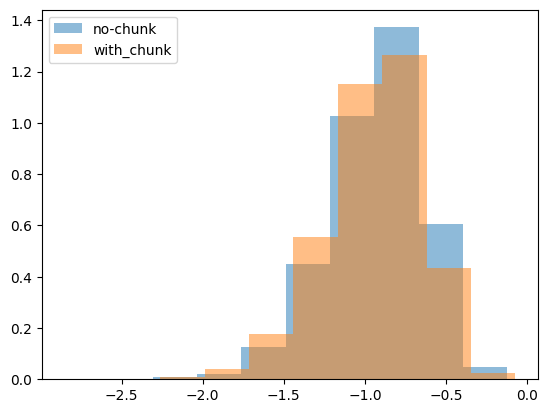

In [23]:
plt.hist(logreward_prioritized.cpu(), alpha=0.5, label="no-chunk", density=True)
plt.hist(logreward_chunk.cpu(), alpha=0.5, label="with_chunk", density=True)
plt.legend()

In [27]:
chunk_indices = torch.topk(logreward_chunk, k=100).indices
prioritized_indices = torch.topk(logreward_prioritized, k=100).indices

chunk_strings = [s.replace("<EOS>", "") for s in to_strings(states_chunk[chunk_indices])]
prioritized_strings = [s.replace("<EOS>", "") for s in to_strings(states_prioritized[prioritized_indices])]
d_chunk = []
for i in tqdm(range(len(chunk_strings))):
    for j in range(i+1, len(chunk_strings)):
        d_chunk.append(levenshtein(chunk_strings[i], chunk_strings[j]))

d_prioritized = []
for i in tqdm(range(len(prioritized_strings))):
    for j in range(i+1, len(prioritized_strings)):
        d_prioritized.append(levenshtein(prioritized_strings[i], prioritized_strings[j]))


results = {
    "chunk": [logreward_chunk[chunk_indices].exp().mean().item(), logreward_chunk[chunk_indices].exp().std().item(), torch.tensor(d_chunk).float().mean().item(), torch.tensor(d_chunk).float().std().item()],
    "prioritized": [logreward_prioritized[prioritized_indices].exp().mean().item(), logreward_prioritized[prioritized_indices].exp().std().item(), torch.tensor(d_prioritized).float().mean().item(), torch.tensor(d_prioritized).float().std().item()]
}

df_results = pd.DataFrame.from_dict(results, orient='index',
                       columns=['performance_mean', 'performance_std', 'diversity_mean', 'diversity_std'])
df_results

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,performance_mean,performance_std,diversity_mean,diversity_std
chunk,0.752266,0.047320,7.323838,1.555850
prioritized,0.738837,0.036052,7.609899,1.565678


In [28]:
chunk_50_jobids = [(4699992, 2024), (4699983, 1998)]
prior_50_jobids = [(4700004, 42)]

In [29]:
logreward_chunk = []
states_chunk = []

for (jobid, seed) in tqdm(chunk_50_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, gfn_approach="chunk_replacement", n_samples=2**12)
    logreward_chunk.append(logreward)
    states_chunk.append(state)
   
logreward_chunk = torch.cat(logreward_chunk, dim=0)
states_chunk = torch.cat(states_chunk, dim=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 2024
Seed set to 1998


In [30]:
logreward_prioritized = []
states_prioritized = []

for (jobid, seed) in tqdm(prior_50_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, gfn_approach="no_chunk", n_samples=2**12)
    logreward_prioritized.append(logreward)
    states_prioritized.append(state)

logreward_prioritized = torch.cat(logreward_prioritized, dim=0)
states_prioritized = torch.cat(states_prioritized, dim=0)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 42


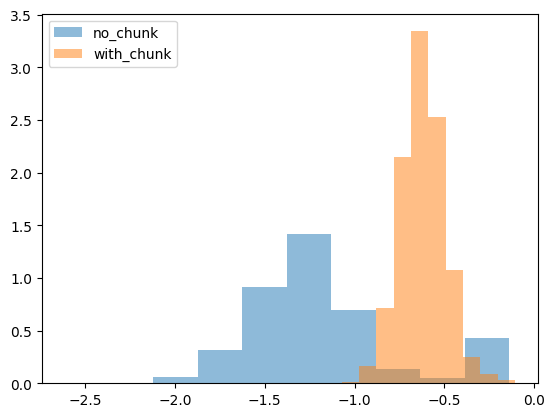

In [31]:
plt.hist(logreward_prioritized.cpu(), alpha=0.5, label="no_chunk", density=True)
plt.hist(logreward_chunk.cpu(), alpha=0.5, label="with_chunk", density=True)
plt.legend()

In [32]:
chunk_indices = torch.topk(logreward_chunk, k=100).indices
prioritized_indices = torch.topk(logreward_prioritized, k=100).indices

chunk_strings = [s.replace("<EOS>", "") for s in to_strings(states_chunk[chunk_indices])]
prioritized_strings = [s.replace("<EOS>", "") for s in to_strings(states_prioritized[prioritized_indices])]
d_chunk = []
for i in tqdm(range(len(chunk_strings))):
    for j in range(i+1, len(chunk_strings)):
        d_chunk.append(levenshtein(chunk_strings[i], chunk_strings[j]))

d_prioritized = []
for i in tqdm(range(len(prioritized_strings))):
    for j in range(i+1, len(prioritized_strings)):
        d_prioritized.append(levenshtein(prioritized_strings[i], prioritized_strings[j]))


results = {
    "chunk": [logreward_chunk[chunk_indices].exp().mean().item(), logreward_chunk[chunk_indices].exp().std().item(), torch.tensor(d_chunk).float().mean().item(), torch.tensor(d_chunk).float().std().item()],
    "prioritized": [logreward_prioritized[prioritized_indices].exp().mean().item(), logreward_prioritized[prioritized_indices].exp().std().item(), torch.tensor(d_prioritized).float().mean().item(), torch.tensor(d_prioritized).float().std().item()]
}

df_results = pd.DataFrame.from_dict(results, orient='index',
                       columns=['performance_mean', 'performance_std', 'diversity_mean', 'diversity_std'])
df_results

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,performance_mean,performance_std,diversity_mean,diversity_std
chunk,0.789381,0.040966,19.481213,3.204795
prioritized,0.816601,0.014582,21.431110,3.375952


In [14]:
chunk_100_jobids = [(4650195, 1998), (4650198, 2024), (4650201, 42), (4650204, 123), (4650207, 5)]
prior_100_jobids = [(4650180, 1998), (4650183, 2024), (4650186, 42), (4650189, 123), (4650192, 5)]

In [15]:
logreward_chunk = []
states_chunk = []

for (jobid, seed) in tqdm(chunk_100_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, n_samples=2**12)
    logreward_chunk.append(logreward)
    states_chunk.append(state)
   
logreward_chunk = torch.cat(logreward_chunk, dim=0)
states_chunk = torch.cat(states_chunk, dim=0)

logreward_prioritized = []
states_prioritized = []

for (jobid, seed) in tqdm(prior_100_jobids):
    logreward, state, actions, trajectories, dones = get_samples(jobid, seed=seed, n_samples=2**12)
    logreward_prioritized.append(logreward)
    states_prioritized.append(state)

logreward_prioritized = torch.cat(logreward_prioritized, dim=0)
states_prioritized = torch.cat(states_prioritized, dim=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Seed set to 1998
Seed set to 2024
Seed set to 42
Seed set to

  0%|          | 0/5 [00:00<?, ?it/s]

Seed set to 1998
Seed set to 2024
Seed set to 42
Seed set to 123
Seed set to 5


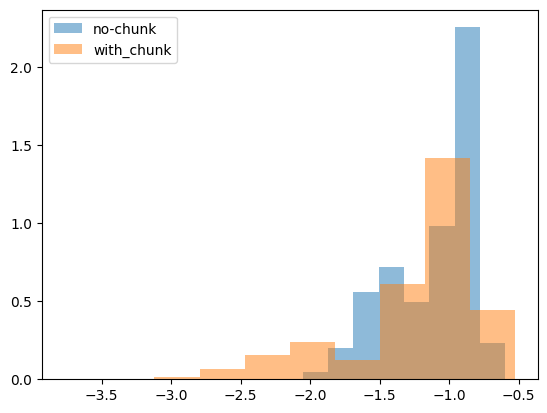

In [16]:
plt.hist(logreward_prioritized.cpu(), alpha=0.5, label="no-chunk", density=True)
plt.hist(logreward_chunk.cpu(), alpha=0.5, label="with_chunk", density=True)
plt.legend()

In [17]:
chunk_indices = torch.topk(logreward_chunk, k=100).indices
prioritized_indices = torch.topk(logreward_prioritized, k=100).indices

chunk_strings = [s.replace("<EOS>", "") for s in to_strings(states_chunk[chunk_indices])]
prioritized_strings = [s.replace("<EOS>", "") for s in to_strings(states_prioritized[prioritized_indices])]
d_chunk = []
for i in tqdm(range(len(chunk_strings))):
    for j in range(i+1, len(chunk_strings)):
        d_chunk.append(levenshtein(chunk_strings[i], chunk_strings[j]))

d_prioritized = []
for i in tqdm(range(len(prioritized_strings))):
    for j in range(i+1, len(prioritized_strings)):
        d_prioritized.append(levenshtein(prioritized_strings[i], prioritized_strings[j]))


results = {
    "chunk": [logreward_chunk[chunk_indices].exp().mean().item(), logreward_chunk[chunk_indices].exp().std().item(), torch.tensor(d_chunk).float().mean().item(), torch.tensor(d_chunk).float().std().item()],
    "prioritized": [logreward_prioritized[prioritized_indices].exp().mean().item(), logreward_prioritized[prioritized_indices].exp().std().item(), torch.tensor(d_prioritized).float().mean().item(), torch.tensor(d_prioritized).float().std().item()]
}

df_results = pd.DataFrame.from_dict(results, orient='index',
                       columns=['performance_mean', 'performance_std', 'diversity_mean', 'diversity_std'])
df_results

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,performance_mean,performance_std,diversity_mean,diversity_std
chunk,0.543049,0.013094,34.010303,2.739903
prioritized,0.509765,0.013007,49.155758,3.019935


# Visualize action embeddings

In [ ]:
chunk_14_jobids = [(4634807, 1998), (4634810, 2024), (4634813, 42), (4634816, 123), (4634819, 5)]


In [148]:
gfn = TBGFN_Variable.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/train/runs/{4634807}/checkpoints/last.ckpt")

ckpt = torch.load(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/train/runs/{4634807}/checkpoints/last.ckpt")
dm_params = ckpt["datamodule_hyper_parameters"]
del dm_params["atomic_tokens"]
del dm_params["max_len"]
del dm_params["sample_exact_length"]
dm = RNABindingModule(**dm_params)
dm.load_state_dict(ckpt["RNABindingModule"])

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_model'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [149]:
action_indices = dm.action_indices
library_embeddings = {}
for action, indices in action_indices.items():
    library_embeddings[action] = gfn.action_model(
            torch.LongTensor(indices).to(gfn.device).unsqueeze(0)
        )
    

In [150]:
dm.actions

['<EOS>',
 'A',
 'C',
 'G',
 'U',
 'GA',
 'UA',
 'GAC',
 'CG',
 'UAGAC',
 'UAGACGA',
 'AUA',
 'GAAUA',
 'CGUAGAC',
 'CGUA',
 'ACGUA',
 'UACG',
 'GAAUAGAC',
 'CCGUA',
 'GAAUAUACG',
 'AUAUAGACGA',
 'ACGUAG',
 'CGAC']

In [145]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [146]:
dim_redux = PCA(n_components=2)
all_embeddings = torch.cat([v for (k,v) in library_embeddings.items()])
redux = dim_redux.fit_transform(all_embeddings.cpu().detach())

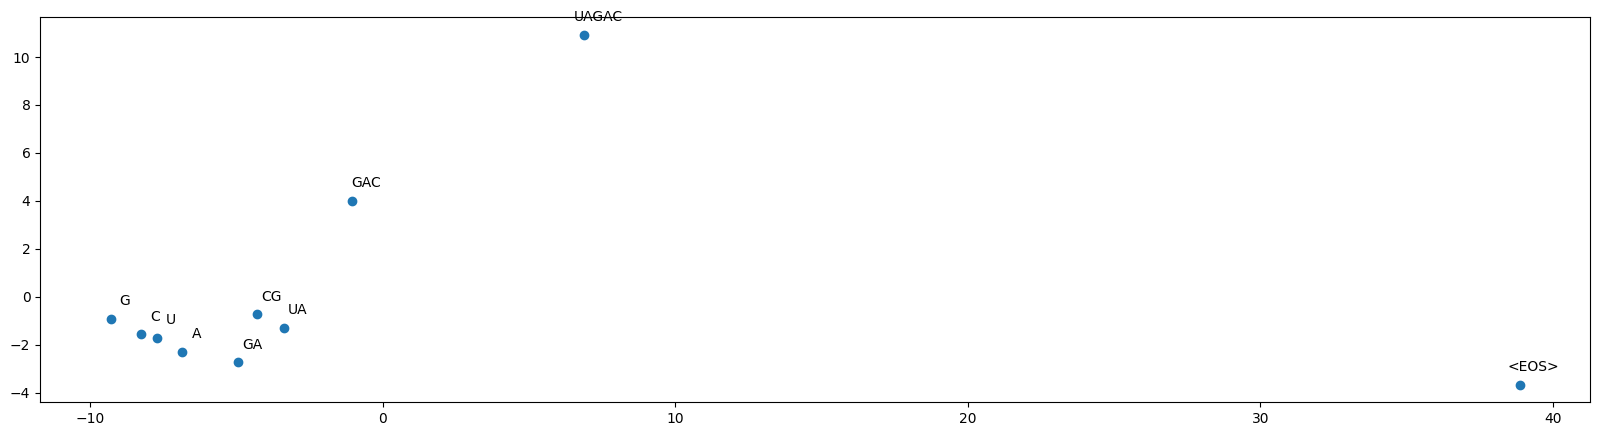

In [147]:
fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(redux[:,0], redux[:,1])
for i, action in enumerate(library_embeddings):
    ax.annotate(action, (redux[i,0], redux[i,1]), textcoords="offset points", xytext=(10,10), ha='center')
plt.show()